In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
class GRU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.gru = nn.GRU(config.input_size, config.hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(config.hidden_size//2, config.output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        gru_out, hidden = self.gru(x, hidden)
        last_output = gru_out[:, -1, :]
        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

# trainer 구현

In [11]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")
    
  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [12]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 6000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_size = 19        # 처음 input의 차원의 개수 (feature수와 같다)
  hidden_size=512        # GRU hidden vector size
  output_size = 2        # output 차원의 개수

config = Config()

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [14]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [15]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


In [16]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 6000
failure(1)의 개수 : 1569


In [17]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [18]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [19]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [20]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 4541
Total number of data samples in valid_loader: 1513
Total number of data samples in test_loader: 1514


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [22]:
# model, optimizer, loss_function 구현하고 결합시키기
model = GRU(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [24]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/6000_GRU') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 6/6 [00:00<00:00, 547.77it/s]


Model saved
TRAIN LOSS = 0.0021575965221903182, TRAIN ACC = 0.762607355208104, 
VALID LOSS = 0.0017372227156311963, VALID ACC = 0.8023793787177792, 
epoch 2


100%|██████████| 6/6 [00:00<00:00, 547.50it/s]


Model saved
TRAIN LOSS = 0.0017654828118532403, TRAIN ACC = 0.8055494384496806, 
VALID LOSS = 0.0016802912978092252, VALID ACC = 0.8162590879048248, 
epoch 3


100%|██████████| 6/6 [00:00<00:00, 559.39it/s]


Model saved
TRAIN LOSS = 0.0016802651350310762, TRAIN ACC = 0.8170006606474345, 
VALID LOSS = 0.001561527486991504, VALID ACC = 0.8400528750826173, 
epoch 4


100%|██████████| 6/6 [00:00<00:00, 565.99it/s]


TRAIN LOSS = 0.0016165749009709293, TRAIN ACC = 0.8161197974014535, 
VALID LOSS = 0.0015141459702657535, VALID ACC = 0.8393919365499009, 
epoch 5


100%|██████████| 6/6 [00:00<00:00, 564.90it/s]


TRAIN LOSS = 0.001523992736232987, TRAIN ACC = 0.8302136093371504, 
VALID LOSS = 0.0014542549631883983, VALID ACC = 0.8393919365499009, 
epoch 6


100%|██████████| 6/6 [00:00<00:00, 568.01it/s]


TRAIN LOSS = 0.0015115962498935143, TRAIN ACC = 0.8354987888130367, 
VALID LOSS = 0.0014528791713777631, VALID ACC = 0.8374091209517515, 
epoch 7


100%|██████████| 6/6 [00:00<00:00, 566.59it/s]


Model saved
TRAIN LOSS = 0.0014553112727486333, TRAIN ACC = 0.8341774939440652, 
VALID LOSS = 0.0014781345024222343, VALID ACC = 0.8446794448116325, 
epoch 8


100%|██████████| 6/6 [00:00<00:00, 564.88it/s]


TRAIN LOSS = 0.0013900381750641508, TRAIN ACC = 0.8427659105923805, 
VALID LOSS = 0.0013085483953169618, VALID ACC = 0.8400528750826173, 
epoch 9


100%|██████████| 6/6 [00:00<00:00, 564.42it/s]


Model saved
TRAIN LOSS = 0.001310640345111184, TRAIN ACC = 0.8418850473463995, 
VALID LOSS = 0.001171032837188882, VALID ACC = 0.8592200925313945, 
epoch 10


100%|██████████| 6/6 [00:00<00:00, 568.63it/s]


TRAIN LOSS = 0.0012312958029707317, TRAIN ACC = 0.8478308742567716, 
VALID LOSS = 0.0012579821271763996, VALID ACC = 0.8578982154659617, 
epoch 11


100%|██████████| 6/6 [00:00<00:00, 563.38it/s]


Model saved
TRAIN LOSS = 0.0012111129332313293, TRAIN ACC = 0.8414446157234089, 
VALID LOSS = 0.001093211921728453, VALID ACC = 0.8625247851949769, 
epoch 12


100%|██████████| 6/6 [00:00<00:00, 565.56it/s]


TRAIN LOSS = 0.0010855282240306667, TRAIN ACC = 0.8524554062981722, 
VALID LOSS = 0.0011611744633433208, VALID ACC = 0.8578982154659617, 
epoch 13


100%|██████████| 6/6 [00:00<00:00, 566.98it/s]


Model saved
TRAIN LOSS = 0.0010551433650125782, TRAIN ACC = 0.8553182118476107, 
VALID LOSS = 0.0009944883802436631, VALID ACC = 0.8678122934567085, 
epoch 14


100%|██████████| 6/6 [00:00<00:00, 566.29it/s]


TRAIN LOSS = 0.0009744467188728667, TRAIN ACC = 0.8606033913234971, 
VALID LOSS = 0.0010479493245177133, VALID ACC = 0.8618638466622605, 
epoch 15


100%|██████████| 6/6 [00:00<00:00, 565.63it/s]


TRAIN LOSS = 0.0009751502400687864, TRAIN ACC = 0.8573001541510681, 
VALID LOSS = 0.0010226129874912069, VALID ACC = 0.8572372769332453, 
epoch 16


100%|██████████| 6/6 [00:00<00:00, 563.40it/s]


TRAIN LOSS = 0.0009738570023832592, TRAIN ACC = 0.8584012332085443, 
VALID LOSS = 0.00105495353014518, VALID ACC = 0.8658294778585591, 
epoch 17


100%|██████████| 6/6 [00:00<00:00, 566.10it/s]


TRAIN LOSS = 0.0009089671346065468, TRAIN ACC = 0.8654481391763928, 
VALID LOSS = 0.000988177575973667, VALID ACC = 0.8631857237276933, 
epoch 18


100%|██████████| 6/6 [00:00<00:00, 568.74it/s]


TRAIN LOSS = 0.0009108173429795336, TRAIN ACC = 0.8612640387579829, 
VALID LOSS = 0.0010410239778444299, VALID ACC = 0.8612029081295439, 
epoch 19


100%|██████████| 6/6 [00:00<00:00, 566.50it/s]


TRAIN LOSS = 0.0009088007640114074, TRAIN ACC = 0.8590618806430301, 
VALID LOSS = 0.0009783030600242085, VALID ACC = 0.8678122934567085, 
epoch 20


100%|██████████| 6/6 [00:00<00:00, 474.15it/s]


Model saved
TRAIN LOSS = 0.0008879217563865206, TRAIN ACC = 0.8590618806430301, 
VALID LOSS = 0.0009756142424969821, VALID ACC = 0.8684732319894249, 
epoch 21


100%|██████████| 6/6 [00:00<00:00, 564.32it/s]


TRAIN LOSS = 0.0008722349551773575, TRAIN ACC = 0.8652279233648976, 
VALID LOSS = 0.0009831966387855242, VALID ACC = 0.8625247851949769, 
epoch 22


100%|██████████| 6/6 [00:00<00:00, 568.13it/s]


TRAIN LOSS = 0.000781844688574928, TRAIN ACC = 0.8669896498568597, 
VALID LOSS = 0.000969933984851648, VALID ACC = 0.8664904163912757, 
epoch 23


100%|██████████| 6/6 [00:00<00:00, 564.75it/s]


TRAIN LOSS = 0.0007707401798360019, TRAIN ACC = 0.8691918079718124, 
VALID LOSS = 0.0010337247922573354, VALID ACC = 0.8684732319894249, 
epoch 24


100%|██████████| 6/6 [00:00<00:00, 568.26it/s]


Model saved
TRAIN LOSS = 0.0007748263794744207, TRAIN ACC = 0.8722748293327461, 
VALID LOSS = 0.0009942193221982867, VALID ACC = 0.8724388631857237, 
epoch 25


100%|██████████| 6/6 [00:00<00:00, 564.95it/s]


TRAIN LOSS = 0.0007336348150827055, TRAIN ACC = 0.8782206562431183, 
VALID LOSS = 0.0008905988632253835, VALID ACC = 0.8691341705221415, 
epoch 26


100%|██████████| 6/6 [00:00<00:00, 558.03it/s]


TRAIN LOSS = 0.0007133536160556631, TRAIN ACC = 0.8755780665051751, 
VALID LOSS = 0.0009351528132111524, VALID ACC = 0.8638466622604097, 
epoch 27


100%|██████████| 6/6 [00:00<00:00, 566.03it/s]


TRAIN LOSS = 0.0007027442255515775, TRAIN ACC = 0.8729354767672319, 
VALID LOSS = 0.0009292607089185747, VALID ACC = 0.8704560475875743, 
epoch 28


100%|██████████| 6/6 [00:00<00:00, 559.34it/s]


Model saved
TRAIN LOSS = 0.0006726359765163683, TRAIN ACC = 0.8830654040960141, 
VALID LOSS = 0.0009183300128458985, VALID ACC = 0.875743555849306, 
epoch 29


100%|██████████| 6/6 [00:00<00:00, 566.22it/s]


Model saved
TRAIN LOSS = 0.0006335691254166773, TRAIN ACC = 0.8909931733098436, 
VALID LOSS = 0.0009387127331212429, VALID ACC = 0.8803701255783212, 
epoch 30


100%|██████████| 6/6 [00:00<00:00, 536.74it/s]


Model saved
TRAIN LOSS = 0.0005891859380454908, TRAIN ACC = 0.8989209425236732, 
VALID LOSS = 0.0008952395654402265, VALID ACC = 0.8896232650363516, 
epoch 31


100%|██████████| 6/6 [00:00<00:00, 559.25it/s]


TRAIN LOSS = 0.0005717566788550962, TRAIN ACC = 0.9068487117375027, 
VALID LOSS = 0.0010123978820133902, VALID ACC = 0.8797091870456047, 
epoch 32


100%|██████████| 6/6 [00:00<00:00, 566.59it/s]


TRAIN LOSS = 0.0006392190117611283, TRAIN ACC = 0.9002422373926448, 
VALID LOSS = 0.0009731059722843662, VALID ACC = 0.8777263714474554, 
epoch 33


100%|██████████| 6/6 [00:00<00:00, 553.90it/s]


TRAIN LOSS = 0.0005740331569134835, TRAIN ACC = 0.9072891433604933, 
VALID LOSS = 0.001022115536895873, VALID ACC = 0.8836748182419035, 
epoch 34


100%|██████████| 6/6 [00:00<00:00, 554.14it/s]


TRAIN LOSS = 0.0005239943914858682, TRAIN ACC = 0.9130147544593702, 
VALID LOSS = 0.0008623089840769846, VALID ACC = 0.8876404494382022, 
epoch 35


100%|██████████| 6/6 [00:00<00:00, 554.06it/s]


TRAIN LOSS = 0.0005266501780938167, TRAIN ACC = 0.916978639066285, 
VALID LOSS = 0.0010197399687625207, VALID ACC = 0.8810310641110377, 
epoch 36


100%|██████████| 6/6 [00:00<00:00, 555.78it/s]


Model saved
TRAIN LOSS = 0.0004983758695376022, TRAIN ACC = 0.921162739484695, 
VALID LOSS = 0.001021631608636507, VALID ACC = 0.891606080634501, 
epoch 37


100%|██████████| 6/6 [00:00<00:00, 556.99it/s]


TRAIN LOSS = 0.0005208911352471564, TRAIN ACC = 0.9141158335168466, 
VALID LOSS = 0.0009480141797604659, VALID ACC = 0.8889623265036352, 
epoch 38


100%|██████████| 6/6 [00:00<00:00, 561.44it/s]


TRAIN LOSS = 0.00044371106306431815, TRAIN ACC = 0.9260074873375909, 
VALID LOSS = 0.000951938326202791, VALID ACC = 0.8869795109054858, 
epoch 39


100%|██████████| 6/6 [00:00<00:00, 563.03it/s]


Model saved
TRAIN LOSS = 0.00042066394633014044, TRAIN ACC = 0.9279894296410482, 
VALID LOSS = 0.0009365403447337129, VALID ACC = 0.900198281559815, 
epoch 40


100%|██████████| 6/6 [00:00<00:00, 558.83it/s]


TRAIN LOSS = 0.00040038890826547233, TRAIN ACC = 0.9301915877560009, 
VALID LOSS = 0.00103564642157999, VALID ACC = 0.8955717118307998, 
epoch 41


100%|██████████| 6/6 [00:00<00:00, 564.89it/s]


TRAIN LOSS = 0.00046101513740591635, TRAIN ACC = 0.9293107245100198, 
VALID LOSS = 0.0009742259132255408, VALID ACC = 0.8929279576999339, 
epoch 42


100%|██████████| 6/6 [00:00<00:00, 570.28it/s]


Model saved
TRAIN LOSS = 0.0004147503010648065, TRAIN ACC = 0.9473684210526315, 
VALID LOSS = 0.0010601542225281136, VALID ACC = 0.906146728354263, 
epoch 43


100%|██████████| 6/6 [00:00<00:00, 563.91it/s]


Model saved
TRAIN LOSS = 0.00035436805259732524, TRAIN ACC = 0.9625633120458049, 
VALID LOSS = 0.0009889653480691146, VALID ACC = 0.913417052214144, 
epoch 44


100%|██████████| 6/6 [00:00<00:00, 569.45it/s]


Model saved
TRAIN LOSS = 0.000294627452363949, TRAIN ACC = 0.9720325919401013, 
VALID LOSS = 0.0010442904148051382, VALID ACC = 0.9160608063450099, 
epoch 45


100%|██████████| 6/6 [00:00<00:00, 570.14it/s]


Model saved
TRAIN LOSS = 0.0003320087470151968, TRAIN ACC = 0.9669676282757101, 
VALID LOSS = 0.0010284866647695123, VALID ACC = 0.9193654990085922, 
epoch 46


100%|██████████| 6/6 [00:00<00:00, 569.03it/s]


TRAIN LOSS = 0.00031721476933893665, TRAIN ACC = 0.9680687073331865, 
VALID LOSS = 0.00103714480080198, VALID ACC = 0.9127561136814276, 
epoch 47


100%|██████████| 6/6 [00:00<00:00, 566.79it/s]


TRAIN LOSS = 0.0002756253347552261, TRAIN ACC = 0.9744549658665492, 
VALID LOSS = 0.0009772711373762192, VALID ACC = 0.9187045604758758, 
epoch 48


100%|██████████| 6/6 [00:00<00:00, 572.59it/s]


TRAIN LOSS = 0.00019991660088241638, TRAIN ACC = 0.979299713719445, 
VALID LOSS = 0.001003166194081858, VALID ACC = 0.9193654990085922, 
epoch 49


100%|██████████| 6/6 [00:00<00:00, 570.20it/s]


Model saved
TRAIN LOSS = 0.00014931429628724965, TRAIN ACC = 0.9852455406298172, 
VALID LOSS = 0.0010755429363219215, VALID ACC = 0.9213483146067416, 
epoch 50


100%|██████████| 6/6 [00:00<00:00, 566.93it/s]


Model saved
TRAIN LOSS = 0.00013895909613881492, TRAIN ACC = 0.9863466196872935, 
VALID LOSS = 0.0011023862997743363, VALID ACC = 0.9299405155320555, 
epoch 51


100%|██████████| 6/6 [00:00<00:00, 569.26it/s]


TRAIN LOSS = 0.00014439850347885684, TRAIN ACC = 0.9870072671217793, 
VALID LOSS = 0.001201965618984477, VALID ACC = 0.9286186384666226, 
epoch 52


100%|██████████| 6/6 [00:00<00:00, 568.53it/s]


TRAIN LOSS = 0.0001276471559594077, TRAIN ACC = 0.9872274829332746, 
VALID LOSS = 0.0012547830064329815, VALID ACC = 0.9180436219431592, 
epoch 53


100%|██████████| 6/6 [00:00<00:00, 569.75it/s]


TRAIN LOSS = 0.00010233953188258996, TRAIN ACC = 0.9922924465976657, 
VALID LOSS = 0.001132501940497167, VALID ACC = 0.9253139458030403, 
epoch 54


100%|██████████| 6/6 [00:00<00:00, 565.03it/s]


Model saved
TRAIN LOSS = 9.43988514459099e-05, TRAIN ACC = 0.9907509359171989, 
VALID LOSS = 0.0011025326325258356, VALID ACC = 0.9319233311302049, 
epoch 55


100%|██████████| 6/6 [00:00<00:00, 570.46it/s]


TRAIN LOSS = 0.0002035527192490974, TRAIN ACC = 0.982602950891874, 
VALID LOSS = 0.001179686383703097, VALID ACC = 0.9213483146067416, 
epoch 56


100%|██████████| 6/6 [00:00<00:00, 569.67it/s]


TRAIN LOSS = 0.0002354824162020449, TRAIN ACC = 0.9786390662849592, 
VALID LOSS = 0.0010748554540641719, VALID ACC = 0.9246530072703238, 
epoch 57


100%|██████████| 6/6 [00:00<00:00, 565.08it/s]


TRAIN LOSS = 0.00017462683334188613, TRAIN ACC = 0.9874476987447699, 
VALID LOSS = 0.0009463545666257829, VALID ACC = 0.9253139458030403, 
epoch 58


100%|██████████| 6/6 [00:00<00:00, 570.60it/s]


Model saved
TRAIN LOSS = 0.000106384407337595, TRAIN ACC = 0.9922924465976657, 
VALID LOSS = 0.0010880058519271377, VALID ACC = 0.9345670852610707, 
epoch 59


100%|██████████| 6/6 [00:00<00:00, 567.99it/s]


Model saved
TRAIN LOSS = 5.5165944669778794e-05, TRAIN ACC = 0.9951552521471042, 
VALID LOSS = 0.0010636995761345652, VALID ACC = 0.9391936549900859, 
epoch 60


100%|██████████| 6/6 [00:00<00:00, 570.69it/s]


TRAIN LOSS = 3.9912710112737574e-05, TRAIN ACC = 0.9973574102620568, 
VALID LOSS = 0.0011571606932612973, VALID ACC = 0.9332452081956378, 
epoch 61


100%|██████████| 6/6 [00:00<00:00, 567.95it/s]


TRAIN LOSS = 2.8086553638043368e-05, TRAIN ACC = 0.9988989209425236, 
VALID LOSS = 0.0012625130847519939, VALID ACC = 0.9352280237937872, 
epoch 62


100%|██████████| 6/6 [00:00<00:00, 570.81it/s]


Model saved
TRAIN LOSS = 3.76031633733717e-05, TRAIN ACC = 0.997577626073552, 
VALID LOSS = 0.0013019351161873585, VALID ACC = 0.9411764705882353, 
epoch 63


100%|██████████| 6/6 [00:00<00:00, 568.94it/s]


TRAIN LOSS = 3.297247869971433e-05, TRAIN ACC = 0.9971371944505616, 
VALID LOSS = 0.0014688046125883466, VALID ACC = 0.930601454064772, 
epoch 64


100%|██████████| 6/6 [00:00<00:00, 567.49it/s]


TRAIN LOSS = 5.400848191004247e-05, TRAIN ACC = 0.9947148205241136, 
VALID LOSS = 0.0014121164392337686, VALID ACC = 0.9339061467283543, 
epoch 65


100%|██████████| 6/6 [00:00<00:00, 570.74it/s]


TRAIN LOSS = 8.567792193853784e-05, TRAIN ACC = 0.9936137414666373, 
VALID LOSS = 0.0015216678361268682, VALID ACC = 0.922009253139458, 
epoch 66


100%|██████████| 6/6 [00:00<00:00, 570.49it/s]


TRAIN LOSS = 0.0001540335727516341, TRAIN ACC = 0.9874476987447699, 
VALID LOSS = 0.0013506638042515506, VALID ACC = 0.9319233311302049, 
epoch 67


100%|██████████| 6/6 [00:00<00:00, 569.61it/s]


TRAIN LOSS = 0.00018371790737747176, TRAIN ACC = 0.985906188064303, 
VALID LOSS = 0.0011170199097818045, VALID ACC = 0.9246530072703238, 
epoch 68


100%|██████████| 6/6 [00:00<00:00, 570.71it/s]


TRAIN LOSS = 0.0001650677886835622, TRAIN ACC = 0.9856859722528077, 
VALID LOSS = 0.0010746336995728033, VALID ACC = 0.9187045604758758, 
epoch 69


100%|██████████| 6/6 [00:00<00:00, 570.60it/s]


TRAIN LOSS = 8.359167056658199e-05, TRAIN ACC = 0.9936137414666373, 
VALID LOSS = 0.0012186900598673495, VALID ACC = 0.9259748843357568, 
epoch 70


100%|██████████| 6/6 [00:00<00:00, 571.22it/s]


TRAIN LOSS = 5.2152631970061336e-05, TRAIN ACC = 0.9964765470160758, 
VALID LOSS = 0.0011141926483531229, VALID ACC = 0.9365499008592201, 
epoch 71


100%|██████████| 6/6 [00:00<00:00, 568.85it/s]


TRAIN LOSS = 2.6890800453569067e-05, TRAIN ACC = 0.9984584893195332, 
VALID LOSS = 0.0011779390575865287, VALID ACC = 0.9372108393919365, 
epoch 72


100%|██████████| 6/6 [00:00<00:00, 572.09it/s]


TRAIN LOSS = 1.0861679823936653e-05, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.0011086764462878195, VALID ACC = 0.9391936549900859, 
epoch 73


100%|██████████| 6/6 [00:00<00:00, 569.22it/s]


Model saved
TRAIN LOSS = 8.547434030480943e-06, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.001125953623733218, VALID ACC = 0.9424983476536682, 
epoch 74


100%|██████████| 6/6 [00:00<00:00, 569.89it/s]


TRAIN LOSS = 5.4806691755008866e-06, TRAIN ACC = 0.9995595683770094, 
VALID LOSS = 0.0012387657157648343, VALID ACC = 0.9398545935228024, 
epoch 75


100%|██████████| 6/6 [00:00<00:00, 569.36it/s]


TRAIN LOSS = 8.457251700357938e-06, TRAIN ACC = 0.9995595683770094, 
VALID LOSS = 0.001235913665028337, VALID ACC = 0.9391936549900859, 
epoch 76


100%|██████████| 6/6 [00:00<00:00, 535.90it/s]


TRAIN LOSS = 1.5506446277966774e-05, TRAIN ACC = 0.9988989209425236, 
VALID LOSS = 0.0013509548545592837, VALID ACC = 0.9385327164573695, 
epoch 77


100%|██████████| 6/6 [00:00<00:00, 564.78it/s]


TRAIN LOSS = 4.124876899914223e-05, TRAIN ACC = 0.9962563312045805, 
VALID LOSS = 0.0012819598880100943, VALID ACC = 0.9385327164573695, 
epoch 78


100%|██████████| 6/6 [00:00<00:00, 569.78it/s]


TRAIN LOSS = 9.251578903349518e-05, TRAIN ACC = 0.9916317991631799, 
VALID LOSS = 0.0013789551114689335, VALID ACC = 0.9226701916721745, 
epoch 79


100%|██████████| 6/6 [00:00<00:00, 571.70it/s]


TRAIN LOSS = 0.00014355008840475595, TRAIN ACC = 0.9885487778022461, 
VALID LOSS = 0.0012130862186857981, VALID ACC = 0.923331130204891, 
epoch 80


100%|██████████| 6/6 [00:00<00:00, 572.77it/s]


TRAIN LOSS = 0.00010375919050613549, TRAIN ACC = 0.9900902884827131, 
VALID LOSS = 0.001112138691203766, VALID ACC = 0.9352280237937872, 
epoch 81


100%|██████████| 6/6 [00:00<00:00, 568.13it/s]


TRAIN LOSS = 3.965437305409054e-05, TRAIN ACC = 0.9973574102620568, 
VALID LOSS = 0.0010919194897514894, VALID ACC = 0.9405155320555189, 
epoch 82


100%|██████████| 6/6 [00:00<00:00, 567.00it/s]


TRAIN LOSS = 1.4245628170194086e-05, TRAIN ACC = 0.999119136754019, 
VALID LOSS = 0.0011586826011508958, VALID ACC = 0.9398545935228024, 
epoch 83


100%|██████████| 6/6 [00:00<00:00, 570.85it/s]


TRAIN LOSS = 1.7635388989136874e-05, TRAIN ACC = 0.9986787051310284, 
VALID LOSS = 0.001219033279012389, VALID ACC = 0.9345670852610707, 
epoch 84


100%|██████████| 6/6 [00:00<00:00, 564.21it/s]


TRAIN LOSS = 2.2327398823992984e-05, TRAIN ACC = 0.9984584893195332, 
VALID LOSS = 0.001216965602552032, VALID ACC = 0.937871777924653, 
epoch 85


100%|██████████| 6/6 [00:00<00:00, 568.46it/s]


TRAIN LOSS = 6.473673261153235e-05, TRAIN ACC = 0.9951552521471042, 
VALID LOSS = 0.001271532276018676, VALID ACC = 0.9358889623265036, 
epoch 86


100%|██████████| 6/6 [00:00<00:00, 565.17it/s]


TRAIN LOSS = 7.460473489448628e-05, TRAIN ACC = 0.9949350363356089, 
VALID LOSS = 0.0013536679591079934, VALID ACC = 0.9286186384666226, 
epoch 87


100%|██████████| 6/6 [00:00<00:00, 567.03it/s]


TRAIN LOSS = 3.821240150240701e-05, TRAIN ACC = 0.9973574102620568, 
VALID LOSS = 0.001224756969652346, VALID ACC = 0.9312623925974884, 
epoch 88


100%|██████████| 6/6 [00:00<00:00, 569.93it/s]


TRAIN LOSS = 3.855413473160981e-05, TRAIN ACC = 0.9971371944505616, 
VALID LOSS = 0.0012459997026162358, VALID ACC = 0.9365499008592201, 
epoch 89


100%|██████████| 6/6 [00:00<00:00, 570.73it/s]


TRAIN LOSS = 6.168406509827725e-05, TRAIN ACC = 0.9947148205241136, 
VALID LOSS = 0.0011789719552609279, VALID ACC = 0.9325842696629213, 
epoch 90


100%|██████████| 6/6 [00:00<00:00, 570.80it/s]


TRAIN LOSS = 3.4971108250533254e-05, TRAIN ACC = 0.9964765470160758, 
VALID LOSS = 0.0012555195453225266, VALID ACC = 0.9358889623265036, 
epoch 91


100%|██████████| 6/6 [00:00<00:00, 570.96it/s]


TRAIN LOSS = 3.7305850216303004e-05, TRAIN ACC = 0.9971371944505616, 
VALID LOSS = 0.001217228711951433, VALID ACC = 0.9339061467283543, 
epoch 92


100%|██████████| 6/6 [00:00<00:00, 570.98it/s]


TRAIN LOSS = 0.00010196339161920964, TRAIN ACC = 0.9911913675401894, 
VALID LOSS = 0.0012430416103710975, VALID ACC = 0.9246530072703238, 
epoch 93


100%|██████████| 6/6 [00:00<00:00, 573.11it/s]


TRAIN LOSS = 0.00012477377519434806, TRAIN ACC = 0.9894296410482273, 
VALID LOSS = 0.0011656391289717933, VALID ACC = 0.9259748843357568, 
epoch 94


100%|██████████| 6/6 [00:00<00:00, 572.46it/s]


TRAIN LOSS = 7.004353531161099e-05, TRAIN ACC = 0.9944946047126184, 
VALID LOSS = 0.0013727120272150437, VALID ACC = 0.9226701916721745, 
epoch 95


100%|██████████| 6/6 [00:00<00:00, 572.09it/s]


TRAIN LOSS = 3.843820769527664e-05, TRAIN ACC = 0.9980180576965426, 
VALID LOSS = 0.0011604644963856335, VALID ACC = 0.9365499008592201, 
epoch 96


100%|██████████| 6/6 [00:00<00:00, 573.89it/s]


TRAIN LOSS = 1.3897255063262038e-05, TRAIN ACC = 0.9988989209425236, 
VALID LOSS = 0.001277381292022937, VALID ACC = 0.9358889623265036, 
epoch 97


100%|██████████| 6/6 [00:00<00:00, 569.09it/s]


TRAIN LOSS = 1.5826806630832597e-05, TRAIN ACC = 0.9988989209425236, 
VALID LOSS = 0.001331304260932761, VALID ACC = 0.9339061467283543, 
epoch 98


100%|██████████| 6/6 [00:00<00:00, 573.33it/s]


TRAIN LOSS = 4.56854794435925e-06, TRAIN ACC = 0.9997797841885048, 
VALID LOSS = 0.0013052284796349826, VALID ACC = 0.9418374091209517, 
epoch 99


100%|██████████| 6/6 [00:00<00:00, 564.65it/s]


TRAIN LOSS = 5.695843766663906e-06, TRAIN ACC = 0.9997797841885048, 
VALID LOSS = 0.0013818322568245464, VALID ACC = 0.9372108393919365, 
epoch 100


100%|██████████| 6/6 [00:00<00:00, 565.88it/s]


TRAIN LOSS = 1.98440228654406e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0013754467891685552, VALID ACC = 0.9398545935228024, 
epoch 101


100%|██████████| 6/6 [00:00<00:00, 569.61it/s]


TRAIN LOSS = 1.1431374246537796e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0014045582216304418, VALID ACC = 0.9418374091209517, 
epoch 102


100%|██████████| 6/6 [00:00<00:00, 571.24it/s]


TRAIN LOSS = 1.0452989557135724e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.001422386116644285, VALID ACC = 0.9405155320555189, 
epoch 103


100%|██████████| 6/6 [00:00<00:00, 572.95it/s]


TRAIN LOSS = 7.029018021881682e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0014388120714119547, VALID ACC = 0.9418374091209517, 
epoch 104


100%|██████████| 6/6 [00:00<00:00, 572.98it/s]


TRAIN LOSS = 6.61295683027701e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0014337708401664234, VALID ACC = 0.9424983476536682, 
epoch 105


100%|██████████| 6/6 [00:00<00:00, 571.69it/s]


TRAIN LOSS = 6.425219418627017e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001460370427318858, VALID ACC = 0.9424983476536682, 
epoch 106


100%|██████████| 6/6 [00:00<00:00, 570.39it/s]


TRAIN LOSS = 5.795263034734359e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001469445392065937, VALID ACC = 0.9424983476536682, 
epoch 107


100%|██████████| 6/6 [00:00<00:00, 570.60it/s]


TRAIN LOSS = 5.798850910217382e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001470561403355217, VALID ACC = 0.9411764705882353, 
epoch 108


100%|██████████| 6/6 [00:00<00:00, 573.61it/s]


TRAIN LOSS = 5.340627619192296e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0014853475508277022, VALID ACC = 0.9411764705882353, 
epoch 109


100%|██████████| 6/6 [00:00<00:00, 572.38it/s]


TRAIN LOSS = 4.3882769582621046e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0014888635650030918, VALID ACC = 0.9411764705882353, 
epoch 110


100%|██████████| 6/6 [00:00<00:00, 573.83it/s]


TRAIN LOSS = 3.687397925165949e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0014946388729502645, VALID ACC = 0.9411764705882353, 
epoch 111


100%|██████████| 6/6 [00:00<00:00, 115.30it/s]


TRAIN LOSS = 3.423606976289901e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015086999454800845, VALID ACC = 0.9411764705882353, 
epoch 112


100%|██████████| 6/6 [00:00<00:00, 569.84it/s]


TRAIN LOSS = 3.9149771572271784e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015388909094552685, VALID ACC = 0.9418374091209517, 
epoch 113


100%|██████████| 6/6 [00:00<00:00, 569.13it/s]


TRAIN LOSS = 3.2202828002627426e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015300736274454505, VALID ACC = 0.9418374091209517, 
epoch 114


100%|██████████| 6/6 [00:00<00:00, 573.07it/s]


TRAIN LOSS = 3.3905549574304153e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015377646554643085, VALID ACC = 0.9418374091209517, 
epoch 115


100%|██████████| 6/6 [00:00<00:00, 570.10it/s]


TRAIN LOSS = 2.624934105788298e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001559485417285347, VALID ACC = 0.9424983476536682, 
epoch 116


100%|██████████| 6/6 [00:00<00:00, 574.05it/s]


TRAIN LOSS = 2.983460554404853e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001560077465139945, VALID ACC = 0.9418374091209517, 
epoch 117


100%|██████████| 6/6 [00:00<00:00, 561.06it/s]


TRAIN LOSS = 2.3165549999026553e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015661563017631474, VALID ACC = 0.9418374091209517, 
epoch 118


100%|██████████| 6/6 [00:00<00:00, 553.90it/s]


TRAIN LOSS = 2.457105691385355e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015590073490331917, VALID ACC = 0.9424983476536682, 
epoch 119


100%|██████████| 6/6 [00:00<00:00, 570.41it/s]


Model saved
TRAIN LOSS = 2.3522903145400842e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015794677956562837, VALID ACC = 0.9431592861863847, 
epoch 120


100%|██████████| 6/6 [00:00<00:00, 569.76it/s]


TRAIN LOSS = 2.281259831831317e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015721503603324462, VALID ACC = 0.9431592861863847, 
epoch 121


100%|██████████| 6/6 [00:00<00:00, 573.15it/s]


TRAIN LOSS = 2.0688855366006005e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015905793443548703, VALID ACC = 0.9431592861863847, 
epoch 122


100%|██████████| 6/6 [00:00<00:00, 570.59it/s]


Model saved
TRAIN LOSS = 1.9539210561038305e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015874046288179547, VALID ACC = 0.9438202247191011, 
epoch 123


100%|██████████| 6/6 [00:00<00:00, 569.85it/s]


TRAIN LOSS = 1.9740619594784483e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015988931187871113, VALID ACC = 0.9438202247191011, 
epoch 124


100%|██████████| 6/6 [00:00<00:00, 570.43it/s]


TRAIN LOSS = 1.8107002075466531e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015946230250955494, VALID ACC = 0.9431592861863847, 
epoch 125


100%|██████████| 6/6 [00:00<00:00, 572.16it/s]


TRAIN LOSS = 1.6835636636349432e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016151004805126808, VALID ACC = 0.9431592861863847, 
epoch 126


100%|██████████| 6/6 [00:00<00:00, 568.73it/s]


TRAIN LOSS = 1.561635437970788e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001608027963944011, VALID ACC = 0.9431592861863847, 
epoch 127


100%|██████████| 6/6 [00:00<00:00, 571.90it/s]


TRAIN LOSS = 1.7229932612306554e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001626268147397971, VALID ACC = 0.9431592861863847, 
epoch 128


100%|██████████| 6/6 [00:00<00:00, 566.17it/s]


TRAIN LOSS = 2.1166307437963242e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016196269470575386, VALID ACC = 0.9431592861863847, 
epoch 129


100%|██████████| 6/6 [00:00<00:00, 570.81it/s]


TRAIN LOSS = 1.7242626021878422e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016326862144218086, VALID ACC = 0.9424983476536682, 
epoch 130


100%|██████████| 6/6 [00:00<00:00, 572.30it/s]


TRAIN LOSS = 1.445140889361387e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001646608902142683, VALID ACC = 0.9431592861863847, 
epoch 131


100%|██████████| 6/6 [00:00<00:00, 572.93it/s]


TRAIN LOSS = 1.2320604989762185e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001629205370138437, VALID ACC = 0.9431592861863847, 
epoch 132


100%|██████████| 6/6 [00:00<00:00, 573.31it/s]


TRAIN LOSS = 1.3011567802725767e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016380281379029047, VALID ACC = 0.9431592861863847, 
epoch 133


100%|██████████| 6/6 [00:00<00:00, 570.36it/s]


TRAIN LOSS = 1.195200439219512e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016483893397621816, VALID ACC = 0.9431592861863847, 
epoch 134


100%|██████████| 6/6 [00:00<00:00, 567.94it/s]


TRAIN LOSS = 1.2215286644922028e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016617219493787808, VALID ACC = 0.9424983476536682, 
epoch 135


100%|██████████| 6/6 [00:00<00:00, 570.11it/s]


TRAIN LOSS = 1.3262585215967318e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016684198095872555, VALID ACC = 0.9418374091209517, 
epoch 136


100%|██████████| 6/6 [00:00<00:00, 572.37it/s]


TRAIN LOSS = 1.1575796605492668e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016676462689378918, VALID ACC = 0.9411764705882353, 
epoch 137


100%|██████████| 6/6 [00:00<00:00, 572.31it/s]


TRAIN LOSS = 1.1129669445790179e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016786612900218977, VALID ACC = 0.9418374091209517, 
epoch 138


100%|██████████| 6/6 [00:00<00:00, 572.05it/s]


TRAIN LOSS = 9.90464227102988e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016864339050991363, VALID ACC = 0.9418374091209517, 
epoch 139


100%|██████████| 6/6 [00:00<00:00, 567.95it/s]


TRAIN LOSS = 9.771389079828203e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016798448637472582, VALID ACC = 0.9418374091209517, 
epoch 140


100%|██████████| 6/6 [00:00<00:00, 569.87it/s]


TRAIN LOSS = 1.0864135006987082e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001692674586257632, VALID ACC = 0.9418374091209517, 
epoch 141


100%|██████████| 6/6 [00:00<00:00, 570.93it/s]


TRAIN LOSS = 1.1928971704250497e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016905165475012054, VALID ACC = 0.9418374091209517, 
epoch 142


100%|██████████| 6/6 [00:00<00:00, 570.51it/s]


TRAIN LOSS = 1.0429503171334211e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016898389927850839, VALID ACC = 0.9418374091209517, 
epoch 143


100%|██████████| 6/6 [00:00<00:00, 572.64it/s]


TRAIN LOSS = 1.0758692525433393e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001702262562627597, VALID ACC = 0.9418374091209517, 
epoch 144


100%|██████████| 6/6 [00:00<00:00, 572.38it/s]


TRAIN LOSS = 8.920074880307311e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017025814061123886, VALID ACC = 0.9418374091209517, 
epoch 145


100%|██████████| 6/6 [00:00<00:00, 573.78it/s]


TRAIN LOSS = 1.1358675424882382e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017189544435376296, VALID ACC = 0.9418374091209517, 
epoch 146


100%|██████████| 6/6 [00:00<00:00, 574.40it/s]


TRAIN LOSS = 1.0275285316101958e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017224869937669813, VALID ACC = 0.9418374091209517, 
epoch 147


100%|██████████| 6/6 [00:00<00:00, 569.30it/s]


TRAIN LOSS = 8.456446326676567e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017154493910227875, VALID ACC = 0.9418374091209517, 
epoch 148


100%|██████████| 6/6 [00:00<00:00, 573.45it/s]


TRAIN LOSS = 7.991683898931058e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001727551714285115, VALID ACC = 0.9418374091209517, 
epoch 149


100%|██████████| 6/6 [00:00<00:00, 570.36it/s]


TRAIN LOSS = 9.879830670732981e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001722482650467519, VALID ACC = 0.9418374091209517, 
epoch 150


100%|██████████| 6/6 [00:00<00:00, 573.01it/s]


TRAIN LOSS = 7.811691813059442e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.00173530778345964, VALID ACC = 0.9418374091209517, 
epoch 151


100%|██████████| 6/6 [00:00<00:00, 571.20it/s]


TRAIN LOSS = 8.677227437342418e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001757554695138219, VALID ACC = 0.9418374091209517, 
epoch 152


100%|██████████| 6/6 [00:00<00:00, 570.42it/s]


TRAIN LOSS = 9.21206722298573e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001744165514292342, VALID ACC = 0.9418374091209517, 
epoch 153


100%|██████████| 6/6 [00:00<00:00, 570.30it/s]


TRAIN LOSS = 7.597656525340054e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001770359047264432, VALID ACC = 0.9418374091209517, 
epoch 154


100%|██████████| 6/6 [00:00<00:00, 571.46it/s]


TRAIN LOSS = 6.347314934504657e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017492347455387153, VALID ACC = 0.9418374091209517, 
epoch 155


100%|██████████| 6/6 [00:00<00:00, 572.13it/s]


TRAIN LOSS = 7.86534685313662e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017582420198159429, VALID ACC = 0.9418374091209517, 
epoch 156


100%|██████████| 6/6 [00:00<00:00, 568.58it/s]


TRAIN LOSS = 7.117878101728988e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017517884677400355, VALID ACC = 0.9418374091209517, 
epoch 157


100%|██████████| 6/6 [00:00<00:00, 570.89it/s]


TRAIN LOSS = 6.119797874948456e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001767751235719241, VALID ACC = 0.9424983476536682, 
epoch 158


100%|██████████| 6/6 [00:00<00:00, 569.40it/s]


TRAIN LOSS = 5.419137106560768e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017616280009237568, VALID ACC = 0.9424983476536682, 
epoch 159


100%|██████████| 6/6 [00:00<00:00, 571.22it/s]


TRAIN LOSS = 7.817892379812091e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017661638434801523, VALID ACC = 0.9424983476536682, 
epoch 160


100%|██████████| 6/6 [00:00<00:00, 567.90it/s]


TRAIN LOSS = 6.23027223958725e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017760167709660703, VALID ACC = 0.9424983476536682, 
epoch 161


100%|██████████| 6/6 [00:00<00:00, 572.28it/s]


TRAIN LOSS = 5.753338535547299e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017762977558496529, VALID ACC = 0.9431592861863847, 
epoch 162


100%|██████████| 6/6 [00:00<00:00, 572.68it/s]


TRAIN LOSS = 6.390526978562899e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001769180112301082, VALID ACC = 0.9431592861863847, 
epoch 163


100%|██████████| 6/6 [00:00<00:00, 570.11it/s]


TRAIN LOSS = 5.9490049244107693e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017845023371727358, VALID ACC = 0.9438202247191011, 
epoch 164


100%|██████████| 6/6 [00:00<00:00, 572.64it/s]


TRAIN LOSS = 6.47571206290838e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001788903606387061, VALID ACC = 0.9438202247191011, 
epoch 165


100%|██████████| 6/6 [00:00<00:00, 570.10it/s]


TRAIN LOSS = 7.16199448314732e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017967510325815688, VALID ACC = 0.9424983476536682, 
epoch 166


100%|██████████| 6/6 [00:00<00:00, 563.93it/s]


TRAIN LOSS = 6.196462720396005e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.00180217938870684, VALID ACC = 0.9424983476536682, 
epoch 167


100%|██████████| 6/6 [00:00<00:00, 566.90it/s]


TRAIN LOSS = 4.717196801702175e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001813531286339845, VALID ACC = 0.9424983476536682, 
epoch 168


100%|██████████| 6/6 [00:00<00:00, 569.66it/s]


TRAIN LOSS = 6.029361044534193e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018055793353444444, VALID ACC = 0.9438202247191011, 
epoch 169


100%|██████████| 6/6 [00:00<00:00, 516.06it/s]


TRAIN LOSS = 4.494894280247737e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018120023365928413, VALID ACC = 0.9424983476536682, 
epoch 170


100%|██████████| 6/6 [00:00<00:00, 567.12it/s]


TRAIN LOSS = 4.880328801572801e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018185432273980725, VALID ACC = 0.9438202247191011, 
epoch 171


100%|██████████| 6/6 [00:00<00:00, 570.38it/s]


TRAIN LOSS = 5.107312311600092e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018114063886326035, VALID ACC = 0.9438202247191011, 
epoch 172


100%|██████████| 6/6 [00:00<00:00, 572.64it/s]


TRAIN LOSS = 4.91517937274282e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001832678746641352, VALID ACC = 0.9438202247191011, 
epoch 173


100%|██████████| 6/6 [00:00<00:00, 541.13it/s]


TRAIN LOSS = 5.7482126786867984e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018278481506466156, VALID ACC = 0.9438202247191011, 
epoch 174


100%|██████████| 6/6 [00:00<00:00, 571.85it/s]


TRAIN LOSS = 4.835707150883625e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001834791165980297, VALID ACC = 0.9438202247191011, 
epoch 175


100%|██████████| 6/6 [00:00<00:00, 349.53it/s]


TRAIN LOSS = 5.299585760478951e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001841352896743946, VALID ACC = 0.9438202247191011, 
epoch 176


100%|██████████| 6/6 [00:00<00:00, 567.48it/s]


TRAIN LOSS = 4.5657195978959046e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018461657846832779, VALID ACC = 0.9438202247191011, 
epoch 177


100%|██████████| 6/6 [00:00<00:00, 571.57it/s]


TRAIN LOSS = 5.0321615314845805e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018457133724290805, VALID ACC = 0.9424983476536682, 
epoch 178


100%|██████████| 6/6 [00:00<00:00, 569.21it/s]


TRAIN LOSS = 4.010680062107262e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018384512969380723, VALID ACC = 0.9418374091209517, 
epoch 179


100%|██████████| 6/6 [00:00<00:00, 555.86it/s]


TRAIN LOSS = 3.853619655390253e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018620525498462685, VALID ACC = 0.9418374091209517, 
epoch 180


100%|██████████| 6/6 [00:00<00:00, 571.46it/s]


TRAIN LOSS = 3.792081723704283e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018415039765937236, VALID ACC = 0.9418374091209517, 
epoch 181


100%|██████████| 6/6 [00:00<00:00, 568.35it/s]


TRAIN LOSS = 4.277058712679287e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018525290040093704, VALID ACC = 0.9418374091209517, 
epoch 182


100%|██████████| 6/6 [00:00<00:00, 570.89it/s]


TRAIN LOSS = 4.6595132618958874e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018486169616827805, VALID ACC = 0.9418374091209517, 
epoch 183


100%|██████████| 6/6 [00:00<00:00, 569.38it/s]


TRAIN LOSS = 4.062546846531607e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018584348473104514, VALID ACC = 0.9411764705882353, 
epoch 184


100%|██████████| 6/6 [00:00<00:00, 574.65it/s]


TRAIN LOSS = 3.549912981897401e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001862481462979112, VALID ACC = 0.9418374091209517, 
epoch 185


100%|██████████| 6/6 [00:00<00:00, 567.51it/s]


TRAIN LOSS = 3.139806529099549e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018610454952961077, VALID ACC = 0.9418374091209517, 
epoch 186


100%|██████████| 6/6 [00:00<00:00, 573.80it/s]


TRAIN LOSS = 4.0380652860594875e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018720454083951356, VALID ACC = 0.9418374091209517, 
epoch 187


100%|██████████| 6/6 [00:00<00:00, 569.83it/s]


TRAIN LOSS = 3.488285577843968e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018747323645083068, VALID ACC = 0.9418374091209517, 
epoch 188


100%|██████████| 6/6 [00:00<00:00, 571.29it/s]


TRAIN LOSS = 4.610090711936226e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018855306539642678, VALID ACC = 0.9418374091209517, 
epoch 189


100%|██████████| 6/6 [00:00<00:00, 571.73it/s]


TRAIN LOSS = 2.7318261578631067e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018782192756226735, VALID ACC = 0.9418374091209517, 
epoch 190


100%|██████████| 6/6 [00:00<00:00, 572.28it/s]


TRAIN LOSS = 3.340165117495117e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001879459194056025, VALID ACC = 0.9418374091209517, 
epoch 191


100%|██████████| 6/6 [00:00<00:00, 569.27it/s]


TRAIN LOSS = 2.9846411650509237e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018885737803308522, VALID ACC = 0.9424983476536682, 
epoch 192


100%|██████████| 6/6 [00:00<00:00, 568.73it/s]


TRAIN LOSS = 3.55118579379561e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001890414748377778, VALID ACC = 0.9424983476536682, 
epoch 193


100%|██████████| 6/6 [00:00<00:00, 564.36it/s]


TRAIN LOSS = 4.862095675995528e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001906611246930316, VALID ACC = 0.9424983476536682, 
epoch 194


100%|██████████| 6/6 [00:00<00:00, 568.58it/s]


TRAIN LOSS = 3.2713265029976646e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001921743095433247, VALID ACC = 0.9424983476536682, 
epoch 195


100%|██████████| 6/6 [00:00<00:00, 570.99it/s]


TRAIN LOSS = 2.852142107388245e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001907685716185283, VALID ACC = 0.9424983476536682, 
epoch 196


100%|██████████| 6/6 [00:00<00:00, 570.87it/s]


TRAIN LOSS = 2.806287686802237e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019200116455042827, VALID ACC = 0.9424983476536682, 
epoch 197


100%|██████████| 6/6 [00:00<00:00, 571.96it/s]


TRAIN LOSS = 2.763032426223566e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019130656361501105, VALID ACC = 0.9424983476536682, 
epoch 198


100%|██████████| 6/6 [00:00<00:00, 572.77it/s]


TRAIN LOSS = 3.267992441829383e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001919705014471494, VALID ACC = 0.9424983476536682, 
epoch 199


100%|██████████| 6/6 [00:00<00:00, 570.87it/s]


TRAIN LOSS = 2.798196313411361e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019202139585599628, VALID ACC = 0.9424983476536682, 
epoch 200


100%|██████████| 6/6 [00:00<00:00, 573.33it/s]

TRAIN LOSS = 3.1397172970742223e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019238233290519134, VALID ACC = 0.9424983476536682, 


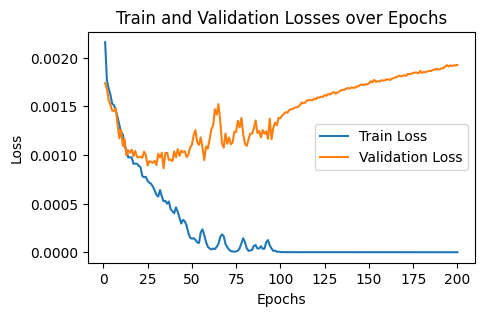

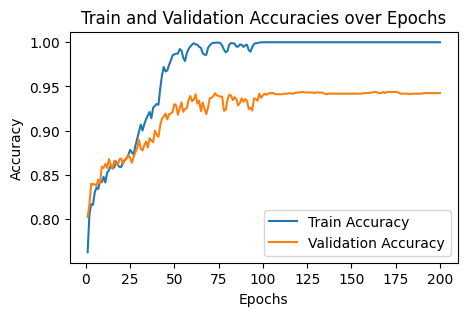

In [25]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [23]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/6000_GRU_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 6/6 [00:00<00:00, 443.79it/s]

Best epoch: 122
macro F1 Score: 0.898346378146102
AUROC: 0.97090279508401
Accuracy: 0.9260237780713342


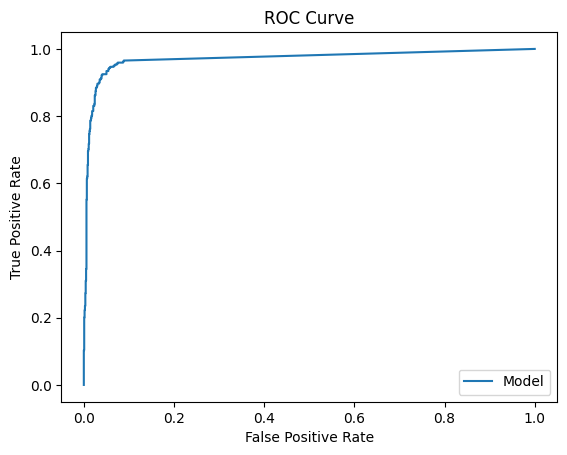

In [27]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)